In [8]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
19,12July_gpt2_10dim_12layer_256_RL,linear_regression,Transformer,,-1,-1,10,12,8,12July_gpt2_10dim_12layer_256_RL
21,12July_mlp_10dim_10layer_1024_RL,linear_regression,12July_mlp_10dim_10layer_1024_RL,,-1,-1,10,10,8,12July_mlp_10dim_10layer_1024_RL
24,12July_mlp_10dim_10layer_512_RL,linear_regression,12July_mlp_10dim_10layer_512_RL,,-1,-1,10,10,8,12July_mlp_10dim_10layer_512_RL
20,12July_mlp_10dim_22layer_1024_RL,linear_regression,12July_mlp_10dim_22layer_1024_RL,,-1,-1,10,22,8,12July_mlp_10dim_22layer_1024_RL
22,12July_mlp_10dim_5layer_1024_RL,linear_regression,12July_mlp_10dim_5layer_1024_RL,,-1,-1,10,5,8,12July_mlp_10dim_5layer_1024_RL
23,12July_mlp_10dim_5layer_512_RL,linear_regression,12July_mlp_10dim_5layer_512_RL,,-1,-1,10,5,8,12July_mlp_10dim_5layer_512_RL
26,24July_lstm_10dim_1layer_256_RL,linear_regression,24July_lstm_10dim_1layer_256_RL,,-1,-1,10,1,8,24July_lstm_10dim_1layer_256_RL
28,24July_lstm_10dim_5layer_256_RL,linear_regression,24July_lstm_10dim_5layer_256_RL,,-1,-1,10,5,8,24July_lstm_10dim_5layer_256_RL
25,24July_lstm_20dim_1layer_256_RL,linear_regression,24July_lstm_20dim_1layer_256_RL,,-1,-1,20,1,8,24July_lstm_20dim_1layer_256_RL
29,24July_lstm_20dim_5layer_256_RL,linear_regression,24July_lstm_20dim_5layer_256_RL,,-1,-1,20,5,8,24July_lstm_20dim_5layer_256_RL


In [10]:
"""
in our case, use linear regression
"""

task = "linear_regression" 
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

"""
Replace run_id
"""
run_id = "6Augtest_moreincontextexample_lstm_3dim_1layer_256_lr1e-4_dropout0.1"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Plot pre-computed metrics

6Augtest_moreincontextexample_lstm_3dim_1layer_256_lr1e-4_dropout0.1 6Augtest_moreincontextexample_lstm_3dim_1layer_256_lr1e-4_dropout0.1


100%|██████████| 15/15 [00:00<00:00, 219980.98it/s]

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [1.036934534708659, 0.6374278465906779, 0.33141974608103436, 0.040538604060808815, 0.009613006065289179, 0.005799253781636556, 0.002164045969645182], 'std': [2.208221435546875, 1.542241891225179, 0.8340318202972412, 0.1504511038462321, 0.04622182250022888, 0.0401670237382253, 0.005771151433388392], 'bootstrap_low': [0.9449043273925781, 0.5684063037236532, 0.29522260030110675, 0.03401389469703039, 0.007651918878157933, 0.004161803362270196, 0.001917261319855849], 'bootstrap_high': [1.1390363375345867, 0.7133770783742269, 0.3696752389272054, 0.04742176334063212, 0.012012731283903122, 0.007974601040283838, 0.0024380249281724295]}, 'Least Squares': {'mean': [0.963282585144043, 0.6810720761617025, 0.3727695941925049, 8.508851031171123e-11, 2.2905350214920867e-13, 6.5445131049111e-14, 5.741622093856831e-14], 'std': [1.9648907979329426, 1.7754712104797363, 1.1495776971181233, 2.8429128

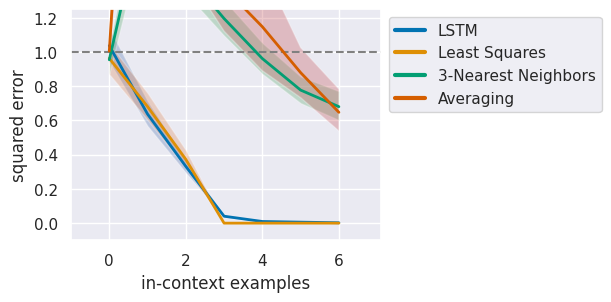

In [11]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
basic_plot(metrics["standard"], models=models)
plt.show()

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.8748409748077393, 0.033176958560943604, 0.015576196213563284, 0.01284163569410642, 0.010389100760221481, 0.006318848580121994, 0.005286070828636487], 'std': [2.2656261126200357, 0.3507855733235677, 0.039116191367308296, 0.03477384398380915, 0.031145361562569935, 0.026665141185124714, 0.02169551948706309], 'bootstrap_low': [0.7735191980997721, 0.01840151349703471, 0.013821173459291458, 0.011221129447221756, 0.009084290514389673, 0.005149322872360547, 0.004345741743842761], 'bootstrap_high': [0.9895528157552084, 0.05196159581343333, 0.017261190960804623, 0.01451879988114039, 0.01176884522040685, 0.007841097811857859, 0.006395586455861728]}, 'Least Squares': {'mean': [0.8661356767018636, 3.313090994403143e-14, 4.139030336640833e-14, 3.856716288200048e-14, 3.619088987550969e-14, 3.8963849869367663e-14, 3.568970160999658e-14], 'std': [2.0309794743855796, 2.3931390361863386e-13, 1.

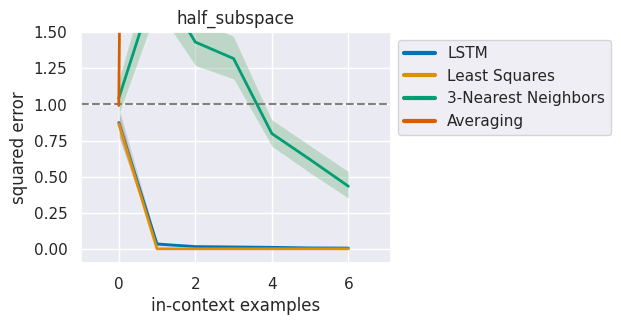

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.9951805273691813, 0.882410446802775, 1.0674809614817302, 1.5008182525634766, 1.1157020727793376, 0.9034761587778727, 0.8040661811828613], 'std': [1.689981460571289, 1.491299311319987, 2.0105554262797036, 2.875662167867025, 2.2644718488057456, 2.006104310353597, 1.6060096422831218], 'bootstrap_low': [0.919719934463501, 0.8192987442016602, 0.9818386236826578, 1.3697017033894856, 1.0124195416768391, 0.8106386661529541, 0.7323088645935059], 'bootstrap_high': [1.0741859277089436, 0.9481561978658041, 1.1725959777832031, 1.635478178660075, 1.2162950833638508, 0.9968882401784261, 0.8784791628519694]}, 'Least Squares': {'mean': [1.0784255663553874, 0.9055368900299072, 1.6692461967468262, 293.6178792317708, 3.4752381642659507, 1.1076695919036865, 0.6033202012379965], 'std': [2.0044752756754556, 1.4565097490946453, 6.155029296875, 5441.361979166667, 41.12042236328125, 5.197606086730957,

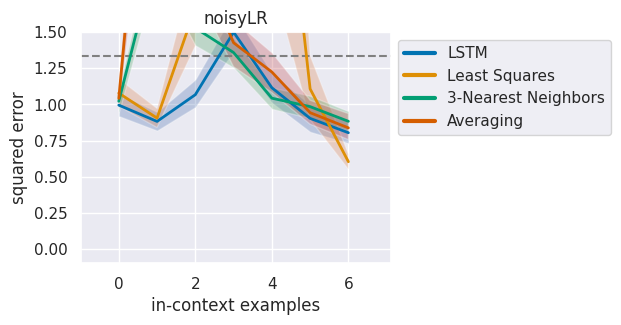

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [1.0603440602620442, 1.052523136138916, 1.0698568026224773, 0.0005909981361279885, 0.0002655252271021406, 0.00018243445083498955, 0.0001671261270530522], 'std': [2.068718910217285, 2.3856824239095054, 2.1608532269795737, 0.0011766513343900442, 0.0006038980015243093, 0.00037782251213987667, 0.00037283213653912145], 'bootstrap_low': [0.969999631245931, 0.9446762402852377, 0.9803131421407064, 0.0005403169197961688, 0.000236779412565132, 0.0001674663508310914, 0.00015200974303297698], 'bootstrap_high': [1.1580719947814941, 1.174841086069743, 1.1705373128255208, 0.0006455200491473079, 0.0002929670736193657, 0.0002008056811367472, 0.00018593591327468553]}, 'Least Squares': {'mean': [0.999712069829305, 1.024319092432658, 0.9585791428883871, 0.0, 0.0, 0.0, 0.0], 'std': [1.8873000144958496, 1.9716798464457195, 1.778944492340088, 0.0, 0.0, 0.0, 0.0], 'bootstrap_low': [0.9164970715840658, 

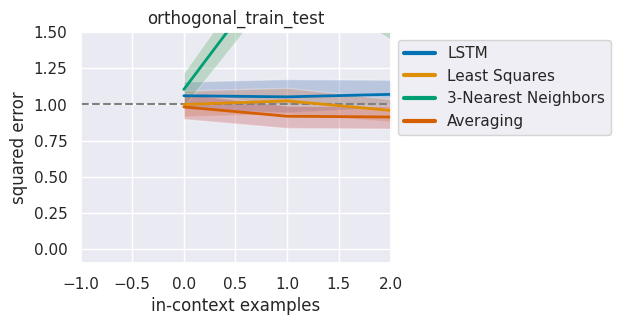

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.9483790397644043, 0.0015888966930409272, 0.003072406786183516, 0.0036246726910273233, 0.0029067182913422585, 0.002022762782871723, 0.0015566116198897362], 'std': [1.9757827123006184, 0.010236358890930811, 0.008784392848610878, 0.008497840414444605, 0.008152347058057785, 0.007733543093005816, 0.005945763240257899], 'bootstrap_low': [0.852302630742391, 0.0012097142947216828, 0.002682956556479136, 0.0032498513658841452, 0.002543060419460138, 0.0017010467126965523, 0.0012935756240040064], 'bootstrap_high': [1.0465564727783203, 0.0020923828706145287, 0.0034867829332749047, 0.004017111845314503, 0.003311385400593281, 0.0023963997761408487, 0.0018568023418386777]}, 'Least Squares': {'mean': [1.002005894978841, 1.5974974751957586e-14, 2.031899677447842e-14, 1.786379610858521e-14, 2.2136340973507678e-14, 2.5795541375682463e-14, 2.3674656708429682e-14], 'std': [1.98986021677653, 8.8633

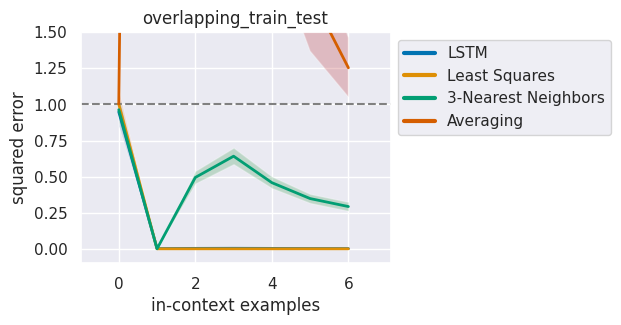

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.94649871190389, 0.6930448214213053, 0.38199468453725177, 0.09129199385643005, 0.02027148629228274, 0.012691440681616465, 0.005255395546555519], 'std': [1.7163632710774739, 1.561374028523763, 0.972891092300415, 0.3897444009780884, 0.07656020919481914, 0.05711465577284495, 0.0222337543964386], 'bootstrap_low': [0.867937962214152, 0.624169667561849, 0.3374977111816406, 0.0743556668361028, 0.016942910850048065, 0.010245557874441147, 0.004342220723628998], 'bootstrap_high': [1.031074047088623, 0.7681630452473959, 0.4293770392735799, 0.11048518617947896, 0.02395392209291458, 0.015463382005691528, 0.006373646979530652]}, 'Least Squares': {'mean': [1.0839428106943767, 0.6277467012405396, 0.3492448329925537, 9.488293484238852e-11, 2.1746533248924912e-13, 8.118360403779982e-14, 7.987230668526912e-14], 'std': [2.2460573514302573, 1.3472878138224285, 0.8543550968170166, 1.947676538568051

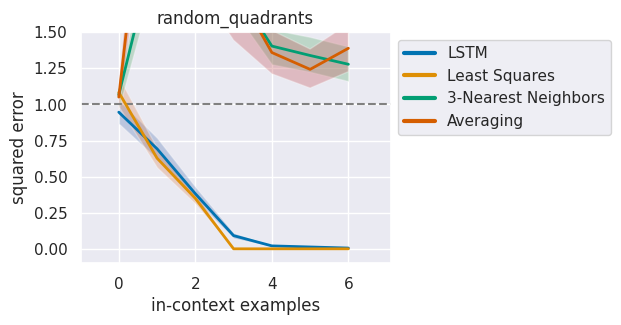

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.11978808045387268, 0.07471976180871327, 0.04084355880816778, 0.013396874070167542, 0.004459295732279618, 0.0019802075500289598, 0.0010681657586246729], 'std': [0.23755141099294028, 0.18593831857045492, 0.12324199080467224, 0.05158359805742899, 0.02648123602072398, 0.007846808061003685, 0.004558772159119447], 'bootstrap_low': [0.10895748933156331, 0.06650089224179585, 0.03552881876627604, 0.011232880254586538, 0.0032626433918873468, 0.0016186819411814213, 0.0008683719982703527], 'bootstrap_high': [0.13038652141888937, 0.08348984519640605, 0.046298056840896606, 0.015946906059980392, 0.0056944725414117174, 0.00234875176101923, 0.0013005572060743968]}, 'Least Squares': {'mean': [0.11379908521970113, 0.07645488778750102, 0.03922456502914429, 8.959845307817312e-13, 5.753077593310951e-14, 6.620795198074928e-15, 5.2216447176322775e-15], 'std': [0.21601015329360962, 0.1707158287366231

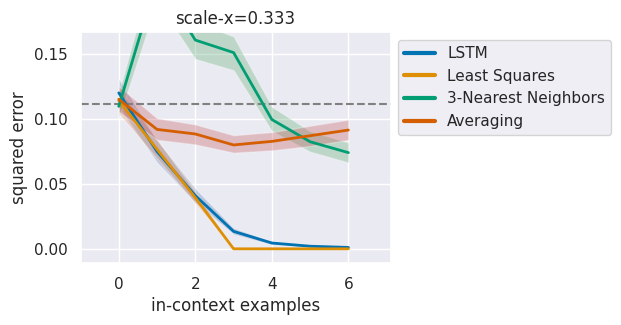

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.269096573193868, 0.16287622849146524, 0.08173619707425435, 0.018338038275639217, 0.004187338675061862, 0.002075787167996168, 0.001343799599756797], 'std': [0.5098829666773478, 0.3496564229329427, 0.22547245025634766, 0.07598033547401428, 0.03602038323879242, 0.017292766521374386, 0.008056216562787691], 'bootstrap_low': [0.24621291955312094, 0.1482259730497996, 0.0715804894765218, 0.014875896275043488, 0.0028856219723820686, 0.0014383122324943542, 0.0010242960415780544], 'bootstrap_high': [0.29258445898691815, 0.18012015024820963, 0.09260257085164388, 0.021970088283220928, 0.006028544157743454, 0.00300872636338075, 0.0017576475317279499]}, 'Least Squares': {'mean': [0.2452468474706014, 0.16481412450472513, 0.08046951393286388, 1.7093709780979793e-10, 4.707042499553273e-14, 1.3489003073156522e-14, 1.2251868537355623e-14], 'std': [0.5022263526916504, 0.336835781733195, 0.2148501

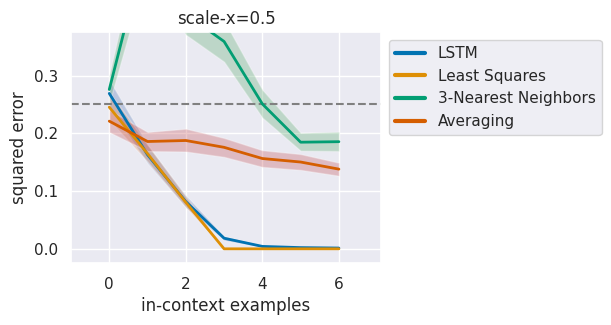

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [3.9444100062052407, 2.570460478464762, 1.6348071098327637, 0.36725417772928876, 0.1846011479695638, 0.08795907100041707, 0.06826085348924], 'std': [8.457632700602213, 5.601430892944336, 4.734366416931152, 1.2304941018422444, 0.7735222975413004, 0.39175935586293537, 0.3778964678446452], 'bootstrap_low': [3.597524642944336, 2.3345921834309897, 1.423035462697347, 0.3136569062868754, 0.1515395442644755, 0.07128637532393138, 0.05230805277824402], 'bootstrap_high': [4.3473326365153, 2.8462788263956704, 1.86747407913208, 0.42901432514190674, 0.22198464473088583, 0.10771886507670085, 0.08678130308787028]}, 'Least Squares': {'mean': [4.128506660461426, 2.354978879292806, 1.438214619954427, 1.2005698287372488e-10, 3.7806053860417466e-13, 2.403914198777224e-13, 1.5780343973088398e-13], 'std': [9.179255803426107, 4.530513763427734, 3.4888060887654624, 3.502072409844459e-09, 2.2461215468579

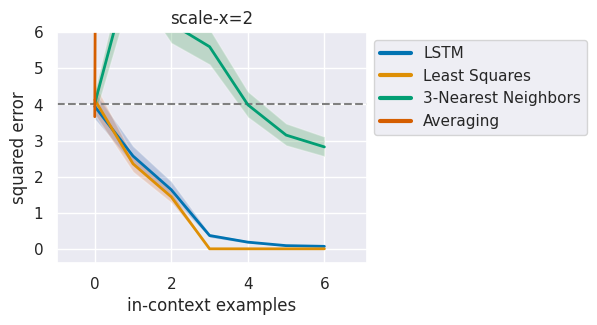

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [8.980133056640625, 6.458815256754558, 4.4972178141276045, 2.5111668904622397, 1.493220329284668, 1.134307622909546, 1.16044282913208], 'std': [18.94434356689453, 13.826685587565104, 12.909772237141928, 7.80994987487793, 4.820894241333008, 4.392780303955078, 6.942047119140625], 'bootstrap_low': [8.09947649637858, 5.851633707682292, 3.95242977142334, 2.158935070037842, 1.2830965518951416, 0.9392963250478109, 0.8875308036804199], 'bootstrap_high': [9.861672083536783, 7.101493199666341, 5.146486918131511, 2.9053478240966797, 1.7297344207763672, 1.3487434387207031, 1.499071439107259]}, 'Least Squares': {'mean': [9.543438593546549, 6.493257522583008, 2.6990486780802407, 2.1836107736798263e-09, 1.2947342850622157e-12, 5.880455989047221e-13, 4.2219804764533536e-13], 'std': [19.112269083658855, 15.253683725992838, 6.574543635050456, 7.601476189241414e-08, 9.627058409715042e-12, 3.650992

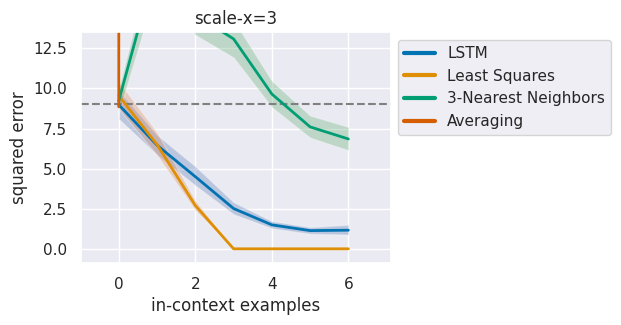

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.10752486189206441, 0.07808842758337657, 0.04344483216603597, 0.010411156962315241, 0.003941979880134265, 0.0018414845690131187, 0.0010671091731637716], 'std': [0.19675840934117636, 0.1802493135134379, 0.10610224803288777, 0.04108827809492747, 0.021527819335460663, 0.006522433832287788, 0.002756249780456225], 'bootstrap_low': [0.09848365187644958, 0.07016362249851227, 0.03855317085981369, 0.008602494994799295, 0.0030577279006441436, 0.0015414462735255559, 0.0009449159260839224], 'bootstrap_high': [0.11671064297358195, 0.08698924382527669, 0.04900843898455302, 0.012287677576144537, 0.0050390008836984634, 0.0021605148601035276, 0.0012088953517377377]}, 'Least Squares': {'mean': [0.10022394855817159, 0.0694485604763031, 0.03991730262835821, 1.3688081339687426e-12, 1.6178815376531133e-13, 5.282358345225571e-15, 5.1674199271035835e-15], 'std': [0.20686022440592447, 0.14316742618878

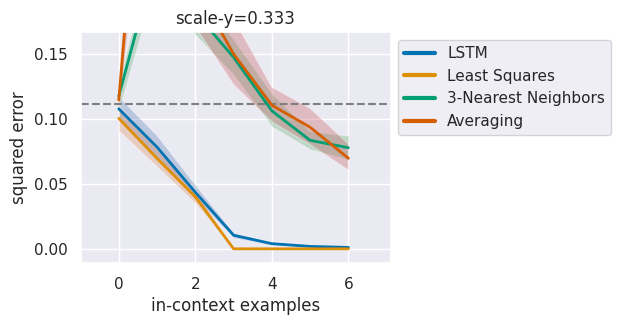

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.23994016647338867, 0.16565545399983725, 0.08513720830281575, 0.01856119806567828, 0.0042387538899978, 0.0018221763893961906, 0.0012273069781561692], 'std': [0.4430447419484456, 0.3793758153915405, 0.22715731461842856, 0.09474891424179077, 0.015102031330267588, 0.005579627429445584, 0.005585208535194397], 'bootstrap_low': [0.21899072329203287, 0.15027079979578653, 0.0751105546951294, 0.01435548315445582, 0.003551177059610685, 0.0015787735270957153, 0.0010022932353119056], 'bootstrap_high': [0.26081732908884686, 0.18435990810394287, 0.09589889645576477, 0.023337244987487793, 0.004924990236759186, 0.002076945578058561, 0.0015015911000470321]}, 'Least Squares': {'mean': [0.24731087684631348, 0.1650728682676951, 0.08269320925076802, 8.662005574616716e-13, 3.381956805893991e-14, 1.5757032045251793e-14, 1.0866075201802541e-14], 'std': [0.5165168841679891, 0.35662086804707843, 0.2184

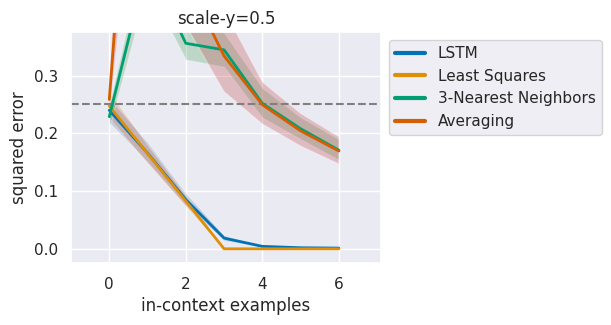

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [4.317946434020996, 2.6816889444986978, 1.4650815327962239, 0.44389088948567706, 0.17727593580881754, 0.08449195822079976, 0.05025545756022135], 'std': [8.438163757324219, 5.929910659790039, 4.440825780232747, 2.440436681111654, 0.772362232208252, 0.4437558650970459, 0.40475110212961835], 'bootstrap_low': [3.9304685592651367, 2.4325310389200845, 1.2702285448710124, 0.34527591864267987, 0.14274374643961588, 0.06489197909832001, 0.034096526602904], 'bootstrap_high': [4.696495691935222, 2.9459616343180337, 1.6650630633036296, 0.5638829072316488, 0.21733335653940836, 0.10683240493138631, 0.07096180319786072]}, 'Least Squares': {'mean': [3.986909548441569, 2.34158992767334, 1.4594329198201497, 1.8398658892711712e-09, 3.4775200658902308e-12, 1.9416814076717026e-13, 1.6835825630024762e-13], 'std': [7.637423197428386, 5.156907717386882, 3.9827133814493814, 4.8365379257120367e-08, 8.8351

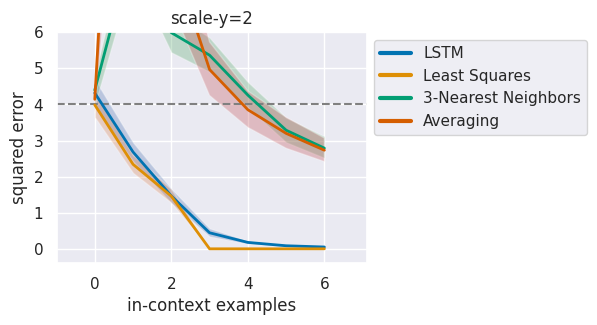

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [7.967474619547526, 5.75782839457194, 3.2263784408569336, 1.7510851224263508, 1.1092957655588787, 0.8048462867736816, 0.7585798104604086], 'std': [15.479755401611328, 12.826605478922525, 7.73728624979655, 5.671941757202148, 4.422814687093099, 3.8557106653849282, 4.102987925211589], 'bootstrap_low': [7.295828501383464, 5.22221565246582, 2.885951360066732, 1.510141372680664, 0.9181488355000814, 0.6364696025848389, 0.5877100626627604], 'bootstrap_high': [8.702109018961588, 6.354712168375651, 3.591859817504883, 2.02016814549764, 1.3367177645365398, 0.9823253949483236, 0.9578242301940918]}, 'Least Squares': {'mean': [9.592081705729166, 6.079959233601888, 3.177039464314779, 1.2446885004161838e-09, 2.7720028240400354e-12, 5.905203265034927e-13, 4.568475950548582e-13], 'std': [19.987106323242188, 12.632461547851562, 10.572447458902994, 3.95296666511058e-08, 4.440865268110864e-11, 2.2931

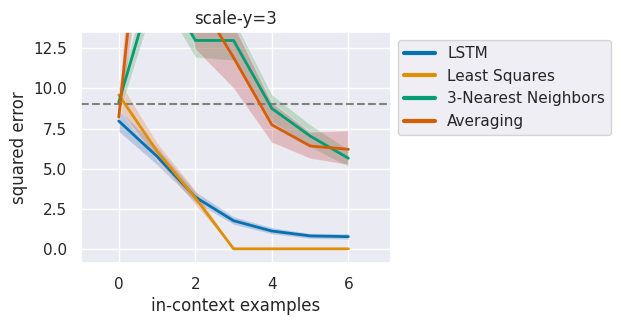

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.946114699045817, 0.46134920914967853, 0.2129129966100057, 0.04390415549278259, 0.016948362191518147, 0.004976158961653709, 0.0030188250044981637], 'std': [1.917248249053955, 1.1654544671376545, 0.7494995594024658, 0.18635876973470053, 0.2065617044766744, 0.03099266191323598, 0.016616308440764744], 'bootstrap_low': [0.8579649130503336, 0.4115712642669678, 0.18252573410669962, 0.03608500212430954, 0.009485301251212755, 0.003751375712454319, 0.002335852632919947], 'bootstrap_high': [1.0368430614471436, 0.5164242188135783, 0.24877444903055826, 0.05259367326895396, 0.027884629865487415, 0.006596631060043971, 0.0038341997812191644]}, 'Least Squares': {'mean': [1.144864797592163, 0.4882289171218872, 0.18697303533554077, 1.4787178888771754e-10, 9.814414905773283e-14, 4.488874820896688e-14, 4.4059432932214613e-14], 'std': [2.7049036026000977, 1.2202675342559814, 0.5767421325047811, 4.

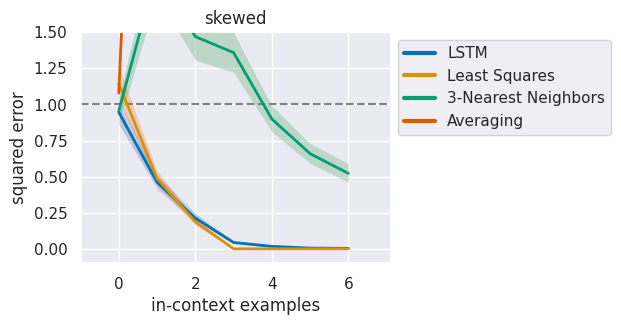

In [12]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [13]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [14]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

self.wpe: Embedding(31, 256)


/home/tianqi/anaconda3/envs/in-context-learning/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [15]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [16]:
with torch.no_grad():

    pred = model(xs, ys)

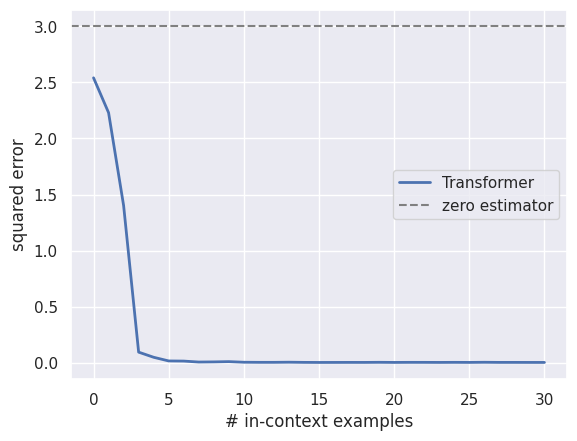

In [17]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [18]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

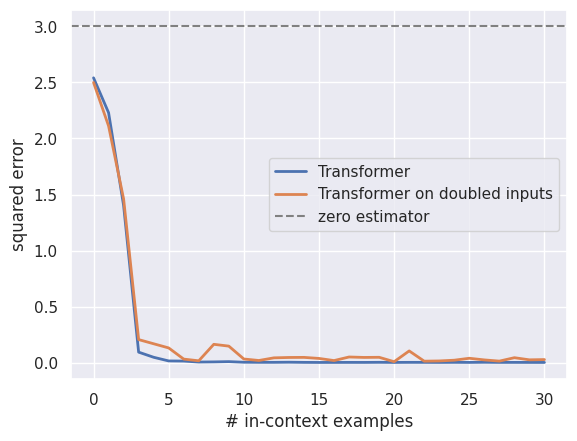

In [19]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.